<a href="https://colab.research.google.com/github/stevenpl98/bluebikes/blob/master/BlueBikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#For Colab -- DO NOT RUN LOCALLY
import os
#Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Set JAVA_HOME path variable in Linux
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version


#Install Spark
#download Spark file
!wget -q http://apache.osuosl.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz 
#extract the file
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
#Set SPARK-HOME path variable in Linux
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


#install findspark package
!pip install -q findspark

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)


In [25]:
import findspark
findspark.init()

In [26]:
# create entry points to spark
try:
    sc.stop()
except:
    pass
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName("bluebikes").setMaster("local[*]")#local[2]
sc=SparkContext(conf = conf)
#spark = SparkSession(sparkContext=sc)

# Imports

In [27]:
import time
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import time

from collections import OrderedDict

from folium import Map
from folium.plugins import HeatMap

from pyspark.sql import SQLContext, DataFrame
from functools import reduce
from pyspark.sql.functions import to_timestamp, dayofweek, col, date_format, hour, month, lit

from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

spark = SQLContext(sc)

# Helpers

In [28]:
def parse_date(text):
    for fmt in ('%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M:%S.%f','%m/%d/%Y %H:%M'):
        try:
            temp = datetime.strptime(text, fmt)
            return(temp.strftime('%Y-%m-%d %H:%M'))
        except ValueError:
            pass
    return(test)

convert_date = udf(lambda x: parse_date(x), StringType())

In [29]:
rushhour = [6,7,8,9,16,17,18]

def time_category(x):
    if x in rushhour:
        return('Rush Hour')
    return('Off Commuting Hours')

time_block = udf(lambda x: time_category(x), StringType())

In [30]:
def convert_usertype(x):
    if x == 'Member':
        return('Subscriber')
    if x == 'Casual':
        return('Customer')
    return(x)

clean_usertype = udf(lambda x: convert_usertype(x), StringType())

In [31]:
def RemoveHeader(rdd):
  header = rdd.first()
  data = rdd.filter(lambda x: x != header) 
  return (data)

In [32]:
def add_zero_value(rider_list):
    if len(rider_list) != 5:
      rider_list.append(0)
    return(rider_list)

In [33]:
# Format months as example ahead: '1/' or '01' to January and order them
def formatMonth(d):
  changes = {
      '1/':'January',
      '01':'January',
      'January': 'January',
      '2/':'February',
      '02':'February',
      'February':'February',
      '3/':'March',
      '03':'March',
      'March':'March',
      '4/':'April',
      '04':'April',
      'April':'April',
      '5/':'May',
      '05':'May',
      'May':'May',
      '6/':'June',
      '06':'June',
      'June':'June',
      '7/':'July',
      '07':'July',
      'July':'July',
      '8/':'August',
      '08':'August',
      'August':'August',
      '9/':'September',
      '09':'September',
      'September':'September',
      '10':'October',
      'October':'October',
      '11':'November',
      'November':'November',
      '12':'December',
      'December':'December'
  }
  # Re-format months so they are strings
  d2 = dict((changes[key], value) for (key, value) in d.items())

  # Re-order months since some were unordered
  keyorder = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
  d3 = OrderedDict(sorted(d2.items(), key= lambda i: keyorder.index(i[0])))

  return d3

In [34]:
# Gets trip numbers per month for all months in a year
def tripsPerMonth(collection, year):
  trips = pd.DataFrame(collection, columns=["x"]).groupby('x').size().to_dict()

  # Add missing months to 2011-2013
  if year == 2011:
    missing = {
      'January': 0,
      'February': 0,
      'March': 0,
      'April': 0,
      'May': 0,
      'June': 0,
      'December': 0
    }
    trips.update(missing)
  elif(year == 2012):
    missing = {
      'January': 0,
      'February': 0,
      'December': 0
    }
    trips.update(missing)
  elif(year == 2013):
    missing = {
      'January': 0,
      'February': 0,
      'March': 0
    }
    trips.update(missing)
  return trips

In [35]:

# Add appropriate year to each month
def formatYear(d, year):
  changes = {
      'January':'January {}'.format(year),
      'February':'February {}'.format(year),
      'March':'March {}'.format(year),
      'April':'April {}'.format(year),
      'May':'May {}'.format(year),
      'June':'June {}'.format(year),
      'July':'July {}'.format(year),
      'August':'August {}'.format(year),
      'September':'September {}'.format(year),
      'October':'October {}'.format(year),
      'November':'November {}'.format(year),
      'December':'December {}'.format(year)
  }
  d2 = dict((changes[key], value) for (key, value) in d.items())

  return d2

In [36]:
# Count function for bikes and stations, adds to dictionary
def toDict(d, collection, year):
  d.update({year: len(collection)})
  return d

# Test Things

In [37]:
test = sc.textFile('./drive/My Drive/Big Data/data/Bikes Data/Years/2019.csv')
#test = sc.textFile('./drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2011.csv')
test.take(3)

['tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender',
 '386,2019-11-01 00:00:00.2770,2019-11-01 00:06:26.7360,189,Kendall T,42.362427842912396,-71.08495473861693,178,MIT Pacific St at Purrington St,42.359573201090434,-71.10129475593567,2511,Subscriber,1993,1',
 '438,2019-11-01 00:01:48.9620,2019-11-01 00:09:07.7670,69,Coolidge Corner - Beacon St at Centre St,42.341598,-71.123338,86,Brookline Village - Station Street at MBTA,42.332998919950704,-71.11634425762531,5523,Customer,1969,0']

In [38]:
#12/31/2014 23:58
start = time.time()

def try_parsing_date(text):
    for fmt in ('%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M:%S.%f','%m/%d/%Y %H:%M'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('String "'+ text +'" could not convert to Datetime')

In [39]:
#Extracting Years, then going to begin separating by month
rdd = sc.textFile('./drive/My Drive/Big Data/data/Bikes Data/cleaned_data.csv')
mappedrdd = rdd.map(lambda x:x.split(','))

In [40]:
def set_age_group(current,val):
    try:
      year = int(current) - int(val)
      if year < 18:
        return('under 18')
      elif year < 25:
        return('18 - 24')
      elif year < 40:
        return('25 - 39')
      elif year < 60:
        return('40 - 59')
      else:
        return('60+')
    except:
      return('error')

# Ridership by Age Group

In [41]:
years = ['/2011','/2012','/2013','/2014','2020-']

dates = mappedrdd.map(lambda x: (x[1], x[-2], x[-3]) )

cleaned = dates.filter(lambda x: not any(val in x[0] for val in years)).filter(lambda x: x[1] != '\\N' and x[1] != '')

In [42]:
age_groups = cleaned.map(lambda x: (try_parsing_date(x[0]),x[1][0:4]))
#age_groups.take(3)

In [43]:
prep_reduce = age_groups.map(lambda x: (( x[0].year, x[0].month, set_age_group(x[0].year ,x[1])), 1)).filter(lambda x: x[1] != 'error')
vals = prep_reduce.reduceByKey(lambda x, y: x + y)

In [44]:
months2020 = dates.filter(lambda x: '2020-' in x[0]).map(lambda x: (x[0], x[2]))
#months2020.take(3)
age_groups2020 = months2020.map(lambda x: (try_parsing_date(x[0]),x[1][0:4]))

prep_reduce2020 = age_groups2020.map(lambda x: (( x[0].year, x[0].month, set_age_group(x[0].year ,x[1])), 1)).filter(lambda x: x[1] != 'error')
vals2020 = prep_reduce2020.reduceByKey(lambda x, y: x + y)

In [45]:
grouped_vals = sc.union([vals,vals2020])

In [46]:
#combine = vals.sortBy(lambda x: x[0]).collect()

combine = grouped_vals.map(lambda x: ((x[0][0], x[0][1]), [(x[0][2],x[1])]))

prep = combine.reduceByKey(lambda x, y: x + y).map(lambda x: (x[0], [item[1] for item in sorted(x[1])]))

out = prep.map(lambda x: (x[0], add_zero_value(x[1]))).sortBy(lambda x: x[0]).collect()

#for item in out:
#  print(item)


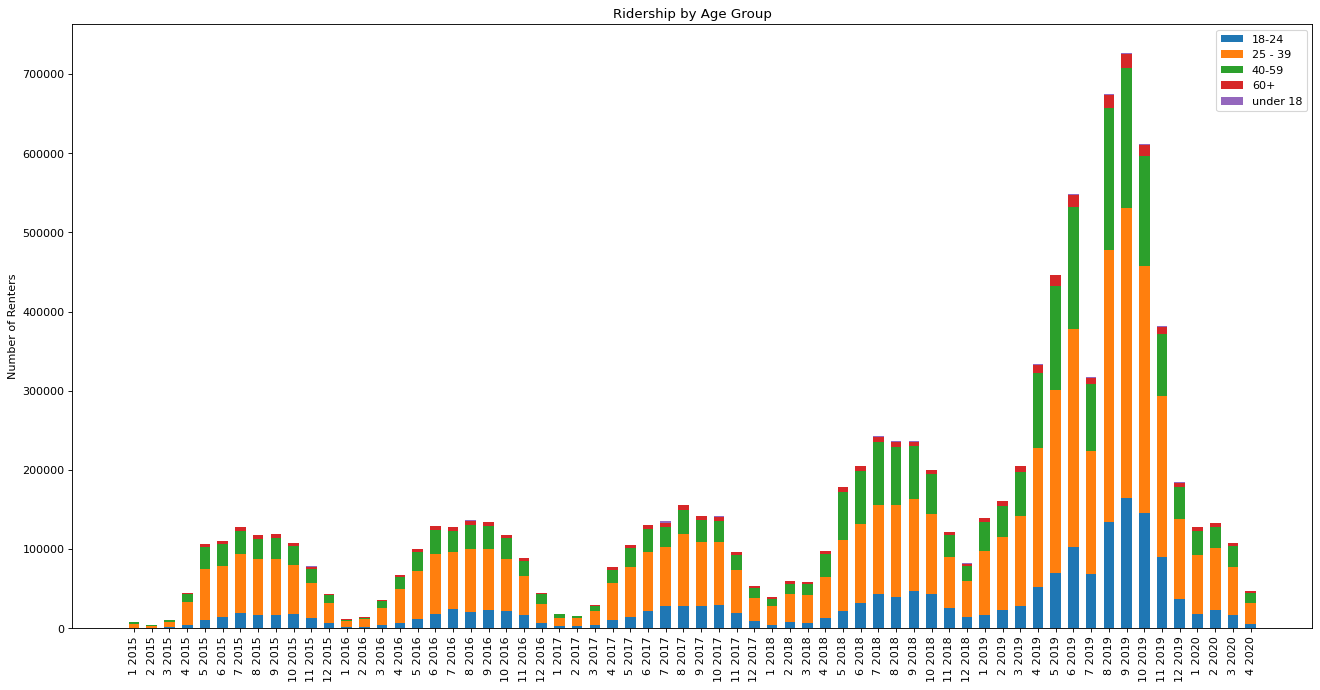

In [47]:
out1 = out[:-2]

fig, ax = plt.subplots(num=None, figsize=(20, 10), dpi=80)

labels = [str(item[0][1]) + ' ' + str(item[0][0]) for item in out1]

one = np.array([item[1][0] for item in out1])
two = np.array([item[1][1] for item in out1])
three = np.array([item[1][2] for item in out1])
four = np.array([item[1][3] for item in out1])
five = np.array([item[1][4] for item in out1])

width = .6

ax.bar(labels, one, width,  label='18-24')
ax.bar(labels, two, width,  bottom=one,label='25 - 39')
ax.bar(labels, three, width,  bottom=two+one,label='40-59')
ax.bar(labels, four, width,  bottom=one+two+three,label='60+')
ax.bar(labels, five, width,  bottom=one + two + three + four,label='under 18')


ax.set_ylabel('Number of Renters')
ax.set_title('Ridership by Age Group')
ax.legend()
plt.xticks(rotation='vertical')

plt.show()

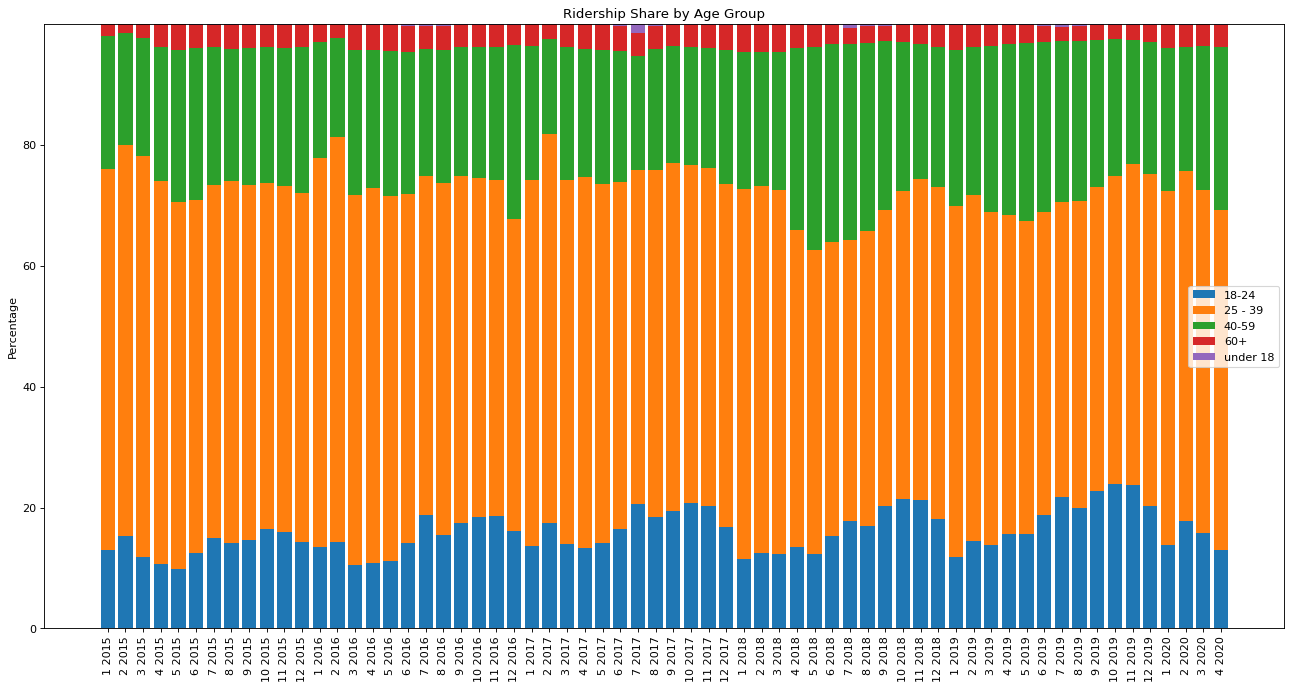

In [48]:
fig, ax = plt.subplots(num=None, figsize=(20, 10), dpi=80)

labels = [str(item[0][1]) + ' ' + str(item[0][0]) for item in out1]

percent = np.array([sum(item[1]) for item in out1])

one_percent = np.round_(([float(x) for x in one] / percent) * 100, 5)
two_percent = np.round_(([float(x) for x in two] / percent) * 100, 5)
three_percent = np.round_(([float(x) for x in three] / percent) * 100, 5)
four_percent = np.round_(([float(x) for x in four] / percent) * 100, 5)
five_percent = np.round_(([float(x) for x in five] / percent) * 100, 5)

width = .8

ax.bar(labels, one_percent, width,  label='18-24')
ax.bar(labels, two_percent, width,  bottom=one_percent,label='25 - 39')
ax.bar(labels, three_percent, width,  bottom=two_percent + one_percent,label='40-59')
ax.bar(labels, four_percent, width,  bottom=two_percent + one_percent + three_percent,label='60+')
ax.bar(labels, five_percent, width,  bottom=two_percent + one_percent + three_percent + four_percent,label='under 18')


ax.set_ylabel('Percentage')
ax.set_title('Ridership Share by Age Group')
ax.legend()
plt.xticks(rotation='vertical')

plt.show()

# Breakdown by Time Period

In [49]:
#test = sc.textFile('./drive/My Drive/Big Data/data/Bikes Data/Years/2020.csv')
test = sc.textFile('./drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2011.csv')
test.take(3)

['Duration,Start date,End date,Start station number,Start station name,End station number,End station name,Bike number,Member type,Zip code,Gender',
 '1712320,11/30/2011 23:58,12/1/2011 0:26,D32005,Boston Public Library - 700 Boylston St.,D32011,Stuart St. at Charles St.,B00056,Member,2116,Male',
 '313200,11/30/2011 23:56,12/1/2011 0:01,C32008,Boylston at Fairfield,D32011,Stuart St. at Charles St.,B00133,Casual,,']

In [50]:
rdd11 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2011.csv')).map(lambda x:x.split(','))
rdd12 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2012.csv')).map(lambda x:x.split(','))
rdd13 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2013.csv')).map(lambda x:x.split(','))
rdd14 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2014.csv')).map(lambda x:x.split(','))
rdd15 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2015.csv')).map(lambda x:x.split(','))
rdd16 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2016.csv')).map(lambda x:x.split(','))
rdd17 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2017.csv')).map(lambda x:x.split(','))
rdd18 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2018.csv')).map(lambda x:x.split(','))
rdd19 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2019.csv')).map(lambda x:x.split(','))
rdd20 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2020.csv')).map(lambda x:x.split(','))

In [52]:
trips11 = rdd11.map(lambda x: (x[1], x[8]))
trips12 = rdd12.map(lambda x: (x[1], x[8]))
trips13 = rdd13.map(lambda x: (x[1], x[8]))
trips14 = rdd14.map(lambda x: (x[1], x[8]))

pre2015 = sc.union([trips11, trips12, trips13, trips14])

pre2015_datetime = pre2015.map(lambda x: (try_parsing_date(x[0]), x[1]))

#pre2015_pre

# Cleaning RDDS

In [ ]:
# Clean rdds

rdd2011 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2011.csv')
rdd2012 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2012.csv')
rdd2013 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2013.csv')
rdd2014 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2014.csv')
rdd2015 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2015.csv')
rdd2016 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2016.csv')
rdd2017 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2017.csv')
rdd2018 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2018.csv')
rdd2019 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2019.csv')
rdd2020 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2020.csv')

cleaned_rdd = sc.union([RemoveHeader(rdd2011),RemoveHeader(rdd2012),RemoveHeader(rdd2013),RemoveHeader(rdd2014),RemoveHeader(rdd2015),
                       RemoveHeader(rdd2016),RemoveHeader(rdd2017),RemoveHeader(rdd2018),RemoveHeader(rdd2019),RemoveHeader(rdd2020)])
cleaned_rdd.saveAsTextFile('/content/drive/My Drive/Big Data/data/Bikes Data/cleaned_data.csv')


In [54]:
start = time.time()
#out = pd.DataFrame(cleaned_rdd.collect())
#out = cleaned_rdd.collect()
#print(str(time.time() - start))
#out.to_csv('/content/drive/My Drive/Big Data/data/Bikes Data/cleaned_data.csv')

# Month vs Month Difference Throughout Years

In [55]:
# Clean year rdds
rdd11 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2011.csv')).map(lambda x:x.split(','))
rdd12 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2012.csv')).map(lambda x:x.split(','))
rdd13 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2013.csv')).map(lambda x:x.split(','))
rdd14 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2014.csv')).map(lambda x:x.split(','))
rdd15 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2015.csv')).map(lambda x:x.split(','))
rdd16 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2016.csv')).map(lambda x:x.split(','))
rdd17 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2017.csv')).map(lambda x:x.split(','))
rdd18 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2018.csv')).map(lambda x:x.split(','))
rdd19 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2019.csv')).map(lambda x:x.split(','))
rdd20 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2020.csv')).map(lambda x:x.split(','))

In [56]:
# Month Collection formatting
trips11 = rdd11.map(lambda x: x[1][0:2])
trips12 = rdd12.map(lambda x: x[1][0:2])
trips13 = rdd13.map(lambda x: x[1][0:2])
trips14 = rdd14.map(lambda x: x[1][0:2])
trips15 = rdd15.map(lambda x: x[1][5:7])
trips16 = rdd16.map(lambda x: x[1][5:7])
trips17 = rdd17.map(lambda x: x[1][5:7])
trips18 = rdd18.map(lambda x: x[1][5:7])
trips19 = rdd19.map(lambda x: x[1][5:7])
trips20 = rdd20.map(lambda x: x[1][5:7])

In [57]:
# Month collections
t11 = trips11.collect()
t12 = trips12.collect()
t13 = trips13.collect()
t14 = trips14.collect()
t15 = trips15.collect()
t16 = trips16.collect()
t17 = trips17.collect()
t18 = trips18.collect()
t19 = trips19.collect()
t20 = trips20.collect()

In [58]:
# Get dictionary of monthly trip totals per year
trips2011 = formatYear(formatMonth(tripsPerMonth(t11, 2011)), 2011)
trips2012 = formatYear(formatMonth(tripsPerMonth(t12, 2012)), 2012)
trips2013 = formatYear(formatMonth(tripsPerMonth(t13, 2013)), 2013)
trips2014 = formatYear(formatMonth(tripsPerMonth(t14, 2014)), 2014)
trips2015 = formatYear(formatMonth(tripsPerMonth(t15, 2015)), 2015)
trips2016 = formatYear(formatMonth(tripsPerMonth(t16, 2016)), 2016)
trips2017 = formatYear(formatMonth(tripsPerMonth(t17, 2017)), 2017)
trips2018 = formatYear(formatMonth(tripsPerMonth(t18, 2018)), 2018)
trips2019 = formatYear(formatMonth(tripsPerMonth(t19, 2019)), 2019)
trips2020 = formatYear(formatMonth(tripsPerMonth(t20, 2020)), 2020)

In [59]:
print(trips2011)
print(trips2012)
print(trips2013)
print(trips2014)
print(trips2015)
print(trips2016)
print(trips2017)
print(trips2018)
print(trips2019)
print(trips2020)

{'January 2011': 0, 'February 2011': 0, 'March 2011': 0, 'April 2011': 0, 'May 2011': 0, 'June 2011': 0, 'July 2011': 2729, 'August 2011': 36233, 'September 2011': 40810, 'October 2011': 36326, 'November 2011': 24876, 'December 2011': 0}
{'January 2012': 0, 'February 2012': 0, 'March 2012': 14284, 'April 2012': 44142, 'May 2012': 53480, 'June 2012': 55636, 'July 2012': 70080, 'August 2012': 84842, 'September 2012': 83643, 'October 2012': 76868, 'November 2012': 47399, 'December 2012': 0}
{'January 2013': 0, 'February 2013': 0, 'March 2013': 0, 'April 2013': 63432, 'May 2013': 97682, 'June 2013': 108666, 'July 2013': 131259, 'August 2013': 147776, 'September 2013': 139228, 'October 2013': 138304, 'November 2013': 72378, 'December 2013': 8151}
{'January 2014': 6577, 'February 2014': 6967, 'March 2014': 11261, 'April 2014': 90942, 'May 2014': 141829, 'June 2014': 159897, 'July 2014': 173486, 'August 2014': 174668, 'September 2014': 169637, 'October 2014': 137732, 'November 2014': 77148, '

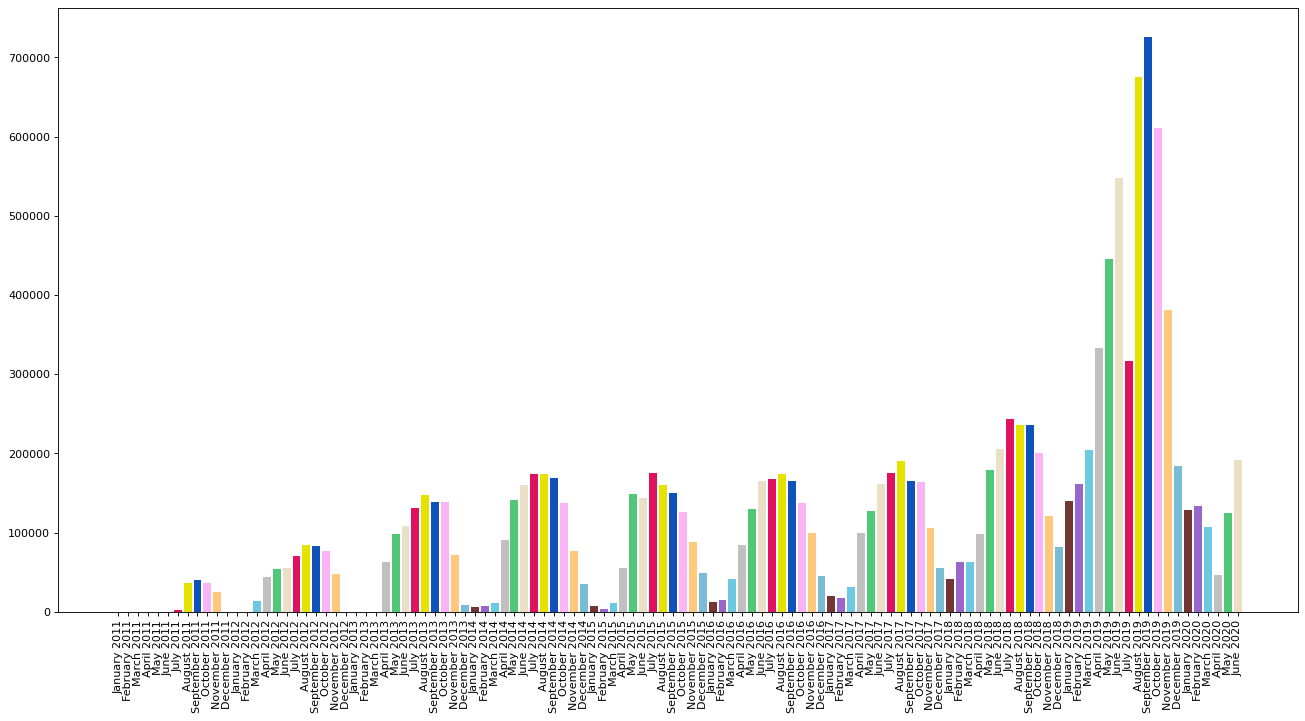

In [60]:
# Plotting monthly trip numbers across years

# Merge all years
trips = {**trips2011, **trips2012, **trips2013, **trips2014, **trips2015, **trips2016, **trips2017, **trips2018, **trips2019, **trips2020}
#print(trips)

fig, ax = plt.subplots(num=None, figsize=(20, 10), dpi=80)
# Birthstone colors to identify months
colors = ['#733635', '#9966cc', '#6bcae2', '#c0c0c0', '#50c878', '#eae0c8', '#e0115f', '#e6e200', '#0f52ba', '#f8b4f4', '#ffc87c', '#78bdd4']
plt.bar(range(len(trips)), list(trips.values()), align='center', orientation='vertical', color= colors)
plt.xticks(range(len(trips)), list(trips.keys()), rotation='vertical')

plt.show()

# COVID-19 Effects

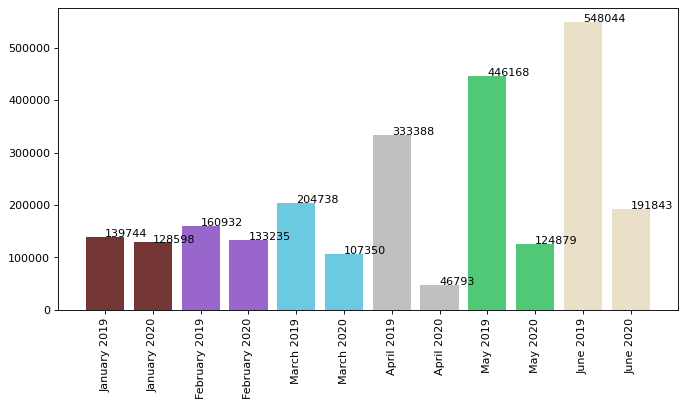

In [61]:
# Compare January through June in 2019 and 2020
fx = {
    'January 2019' : trips['January 2019'],
    'January 2020' : trips['January 2020'],
    'February 2019' : trips['February 2019'],
    'February 2020' : trips['February 2020'],
    'March 2019' : trips['March 2019'],
    'March 2020' : trips['March 2020'],
    'April 2019' : trips['April 2019'],
    'April 2020' : trips['April 2020'],
    'May 2019' : trips['May 2019'],
    'May 2020' : trips['May 2020'],
    'June 2019' : trips['June 2019'],
    'June 2020' : trips['June 2020']
}
fig, ax = plt.subplots(num=None, figsize=(10, 5), dpi=80)
# Birthstone colors to identify months
colors = ['#733635', '#733635', '#9966cc', '#9966cc', '#6bcae2', '#6bcae2', '#c0c0c0', '#c0c0c0', '#50c878', '#50c878', '#eae0c8', '#eae0c8']
plt.bar(range(len(fx)), list(fx.values()), align='center', orientation='vertical', color= colors)
plt.xticks(range(len(fx)), list(fx.keys()), rotation='vertical')

#diff = [dif(trips['January 2020'],trips['January 2019']), dif(trips['January 2020'],trips['January 2019']), dif(trips['January 2020'],trips['January 2019']), dif(trips['January 2020'],trips['January 2019']), dif(trips['January 2020'],trips['January 2019']), dif(trips['January 2020'],trips['January 2019'])]

for index,values in enumerate(list(fx.values())):
  plt.text(x= index , y= values , s= f"{values}" , fontdict= dict(fontsize=10))
plt.show()

# Bikes

In [62]:
# Getting Bikes
bikes11 = rdd11.map(lambda x: x[7]).distinct()
bikes12 = rdd12.map(lambda x: x[7]).distinct()
bikes13 = rdd13.map(lambda x: x[7]).distinct()
bikes14 = rdd14.map(lambda x: x[7]).distinct()
bikes15 = rdd15.map(lambda x: x[11]).distinct()
bikes16 = rdd16.map(lambda x: x[11]).distinct()
bikes17 = rdd17.map(lambda x: x[11]).distinct()
bikes18 = rdd18.map(lambda x: x[11]).distinct()
bikes19 = rdd19.map(lambda x: x[11]).distinct()
bikes20 = rdd20.map(lambda x: x[11]).distinct()

In [63]:
# Collect Bikes IDs
b11 = bikes11.collect()
b12 = bikes12.collect()
b13 = bikes13.collect()
b14 = bikes14.collect()
b15 = bikes15.collect()
b16 = bikes16.collect()
b17 = bikes17.collect()
b18 = bikes18.collect()
b19 = bikes19.collect()
b20 = bikes20.collect()

In [64]:
print(b11)
print(b12)
print(b13)
print(b14)
print(b15)
print(b16)
print(b17)
print(b18)
print(b19)
print(b20)

['B00471', 'B00174', 'B00028', 'B00394', 'B00381', 'B00555', 'B00241', 'B00083', 'B00313', 'B00129', 'B00023', 'B00062', 'B00080', 'B00251', 'B00504', 'B00043', 'B00457', 'B00213', 'B00201', 'B00416', 'B00395', 'B00275', 'B00176', 'B00346', 'B00277', 'B00076', 'B00014', 'B00101', 'B00008', 'B00516', 'B00274', 'B00441', 'B00597', 'B00205', 'B00102', 'B00523', 'B00502', 'B00236', 'B00266', 'B00221', 'B00163', 'B00248', 'B00336', 'B00366', 'B00091', 'B00306', 'B00594', 'B00521', 'B00499', 'B00552', 'B00580', 'B00397', 'B00341', 'B00289', 'B00524', 'B00472', 'B00409', 'B00285', 'B00364', 'B00589', 'B00560', 'B00403', 'B00299', 'B00439', 'B00214', 'B00335', 'B00115', 'B00130', 'B00537', 'B00448', 'B00195', 'B00541', 'B00495', 'B00193', 'B00453', 'B00353', 'B00396', 'B00037', 'B00074', 'B00202', 'B00168', 'B00089', 'B00514', 'B00293', 'B00138', 'B00509', 'B00031', 'B00237', 'B00454', 'B00390', 'B00108', 'B00088', 'B00116', 'B00460', 'B00465', 'B00092', 'B00226', 'B00094', 'B00298', 'B00069',

In [65]:
# Build up the yearly bike counts and add into a dictionary
bikes = {}
toDict(bikes, b11, 2011)
toDict(bikes, b12, 2012)
toDict(bikes, b13, 2013)
toDict(bikes, b14, 2014)
toDict(bikes, b15, 2015)
toDict(bikes, b16, 2016)
toDict(bikes, b17, 2017)
toDict(bikes, b18, 2018)
toDict(bikes, b19, 2019)
toDict(bikes, b20, 2020)

{2011: 605,
 2012: 1036,
 2013: 1141,
 2014: 1301,
 2015: 1488,
 2016: 1802,
 2017: 1799,
 2018: 4045,
 2019: 4652,
 2020: 3608}

In [66]:
print(bikes)

{2011: 605, 2012: 1036, 2013: 1141, 2014: 1301, 2015: 1488, 2016: 1802, 2017: 1799, 2018: 4045, 2019: 4652, 2020: 3608}


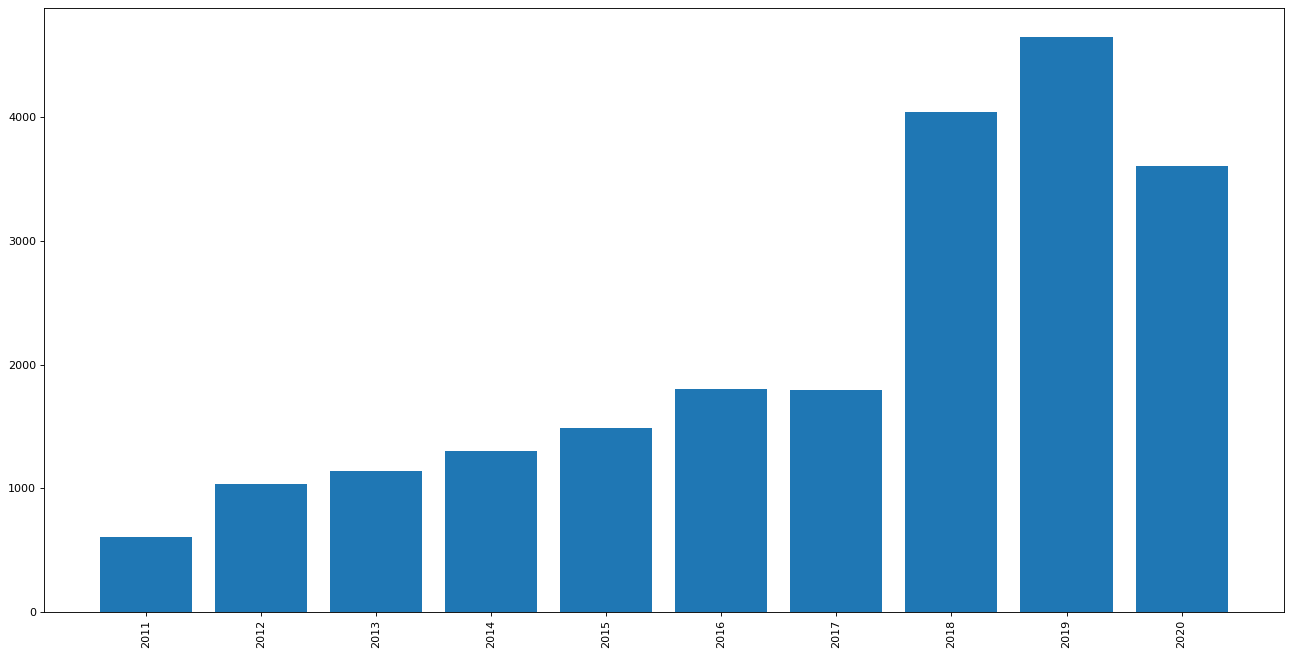

In [67]:
# Plot yearly bike counts
fig, ax = plt.subplots(num=None, figsize=(20, 10), dpi=80)

plt.bar(range(len(bikes)), list(bikes.values()), align='center', orientation='vertical')
plt.xticks(range(len(bikes)), list(bikes.keys()), rotation='vertical')

plt.show()

# Stations

In [68]:
# Get distinct bike ids
stations11 = rdd11.map(lambda x: x[3]).distinct()
stations12 = rdd12.map(lambda x: x[3]).distinct()
stations13 = rdd13.map(lambda x: x[3]).distinct()
stations14 = rdd14.map(lambda x: x[3]).distinct()
stations15 = rdd15.map(lambda x: x[3]).distinct()
stations16 = rdd16.map(lambda x: x[3]).distinct()
stations17 = rdd17.map(lambda x: x[3]).distinct()
stations18 = rdd18.map(lambda x: x[3]).distinct()
stations19 = rdd19.map(lambda x: x[3]).distinct()
stations20 = rdd20.map(lambda x: x[3]).distinct()

In [69]:
# Collect Bikes IDs
s11 = stations11.collect()
s12 = stations12.collect()
s13 = stations13.collect()
s14 = stations14.collect()
s15 = stations15.collect()
s16 = stations16.collect()
s17 = stations17.collect()
s18 = stations18.collect()
s19 = stations19.collect()
s20 = stations20.collect()

In [70]:
print(s11)
print(s12)
print(s13)
print(s14)
print(s15)
print(s16)
print(s17)
print(s18)
print(s19)
print(s20)

['A32001', 'D32016', 'C32003', 'C32007', 'D32014', 'B32004', 'D32006', 'D32000', 'D32003', 'A32006', 'D32017', 'C32009', 'B32015', 'B32003', 'C32002', 'D32012', 'D32013', 'D32009', 'B32010', 'D32008', 'B32018', 'B32013', 'B32017', 'A32003', 'D32005', 'C32008', 'A32009', 'B32008', 'A32004', 'D32011', 'A32010', 'A32011', 'C32000', 'B32012', 'B32007', 'B32005', 'A32000', 'A32005', 'B32002', 'C32004', 'B32006', 'D32001', 'C32001', 'B32000', 'C32006', 'D32007', 'D32002', 'D32004', 'B32014', 'C32010', 'A32012', 'B32016', 'A32007', 'B32019', 'D32015', 'D32010', 'B32011', 'A32002', 'B32009', 'C32005']
['B32005', 'C32010', 'A32012', 'C32007', 'M32024', 'M32010', 'D32019', 'D32016', 'M32018', 'D32004', 'D32006', 'B32008', 'C32003', 'C32009', 'C32000', 'D32014', 'A32001', 'B32007', 'C32001', 'A32007', 'B32017', 'K32003', 'M32038', 'C32015', 'B32000', 'B32016', 'C32008', 'M32023', 'M32001', 'C32014', 'S32007', 'B32011', 'D32020', 'D32023', 'M32006', 'B32002', 'M32037', 'M32002', 'M32016', 'A32006'

In [71]:
# Build up the yearly station counts and add into a dictionary
stations = {}
toDict(stations, s11, 2011)
toDict(stations, s12, 2012)
toDict(stations, s13, 2013)
toDict(stations, s14, 2014)
toDict(stations, s15, 2015)
toDict(stations, s16, 2016)
toDict(stations, s17, 2017)
toDict(stations, s18, 2018)
toDict(stations, s19, 2019)
toDict(stations, s20, 2020)

{2011: 60,
 2012: 105,
 2013: 131,
 2014: 140,
 2015: 156,
 2016: 189,
 2017: 200,
 2018: 315,
 2019: 338,
 2020: 335}

In [72]:
print(stations)

{2011: 60, 2012: 105, 2013: 131, 2014: 140, 2015: 156, 2016: 189, 2017: 200, 2018: 315, 2019: 338, 2020: 335}


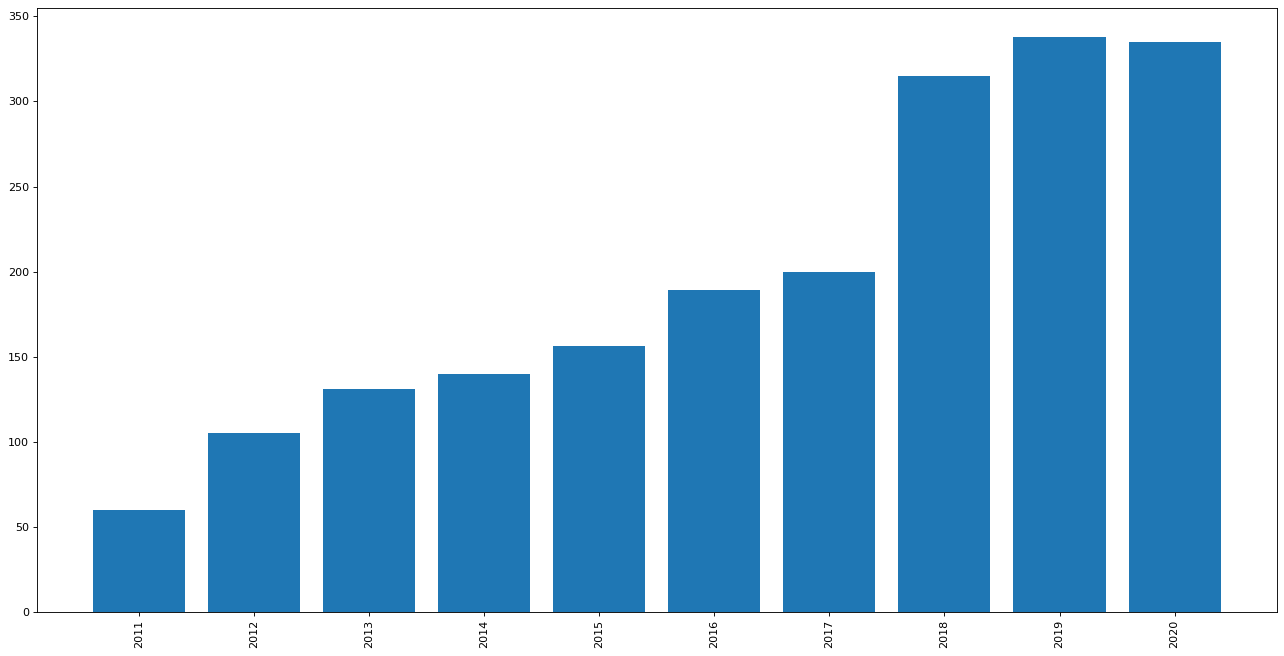

In [73]:
# Plot yearly station counts
fig, ax = plt.subplots(num=None, figsize=(20, 10), dpi=80)

plt.bar(range(len(stations)), list(stations.values()), align='center', orientation='vertical')
plt.xticks(range(len(stations)), list(stations.keys()), rotation='vertical')

plt.show()

# Heatmap

In [74]:
rdd = sc.textFile('./drive/My Drive/Big Data/data/Bikes Data/cleaned_data.csv')
mappedrdd = rdd.map(lambda x:x.split(','))

years = ['2011','2012','2013','2014']

dates = mappedrdd.map(lambda x: (x[1], x[5], x[6]) )

cleaned = dates.filter(lambda x: not any(val in x[0] for val in years)).filter(lambda x: x[1] != '\\N' and x[1] != '')

start_locations = cleaned.map(lambda x: ((x[1], x[2]), 1))

In [75]:
start_reduced = start_locations.reduceByKey(lambda x, y: x + y)

out = start_reduced.map(lambda x: [float(x[0][0]), float(x[0][1]), x[1]]).sortBy(lambda x: x[2]).collect()

In [76]:
val = int(len(out) / 2)
median = float(out[val][2])
avg = float(sum([item[2] for item in out]) / len(out))

average = (avg + median) / 2

modified = [[item[0], item[1], item[2] / average] for item in out]

In [77]:
boston = Map(location=[42.351356, -71.059367], zoom_start=13.75, )

HeatMap(modified).add_to(boston)

boston

# Time Breakdown

In [78]:
df2011 = spark.read.csv('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2011.csv', header = True)
df2012 = spark.read.csv('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2012.csv', header = True)
df2013 = spark.read.csv('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2013.csv', header = True)
df2014 = spark.read.csv('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2014.csv', header = True)
df2015 = spark.read.csv('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2015.csv', header = True)
df2016 = spark.read.csv('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2016.csv', header = True)
df2017 = spark.read.csv('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2017.csv', header = True)
df2018 = spark.read.csv('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2018.csv', header = True)
df2019 = spark.read.csv('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2019.csv', header = True)
df2020 = spark.read.csv('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2020.csv', header = True)

In [79]:
df11 = df2011.select([col for col in df2011.columns if col in ['Start date', 'Member type']])
df12 = df2012.select([col for col in df2012.columns if col in ['Start date', 'Member type']])
df13 = df2013.select([col for col in df2013.columns if col in ['Start date', 'Member type']])
df14 = df2014.select([col for col in df2014.columns if col in ['Start date', 'Member type']])
df15 = df2015.select([col for col in df2015.columns if col in ['starttime', 'usertype']])
df16 = df2016.select([col for col in df2016.columns if col in ['starttime', 'usertype']])
df17 = df2017.select([col for col in df2017.columns if col in ['starttime', 'usertype']])
df18 = df2018.select([col for col in df2018.columns if col in ['starttime', 'usertype']])
df19 = df2019.select([col for col in df2019.columns if col in ['starttime', 'usertype']])
df20 = df2020.select([col for col in df2020.columns if col in ['starttime', 'usertype']])

In [85]:
df_list = [df19,df11,df12,df13,df14,df15,df16,df17,df18,df20]

combined = reduce(DataFrame.unionAll, df_list)

In [86]:
data = combined.select(to_timestamp(convert_date(combined.starttime), format = 'yyyy-MM-dd HH:mm').alias('datetime'),'usertype','starttime')

data = data.withColumn('day_of_week',dayofweek(data.datetime))

data2 = data.select(month("datetime").alias('month'), hour("datetime").alias('hour'), 'usertype','day_of_week')

Traceback (most recent call last):
  File "/content/spark-3.0.0-bin-hadoop3.2/python/pyspark/serializers.py", line 468, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
  File "/content/spark-3.0.0-bin-hadoop3.2/python/pyspark/cloudpickle.py", line 1097, in dumps
    cp.dump(obj)
  File "/content/spark-3.0.0-bin-hadoop3.2/python/pyspark/cloudpickle.py", line 357, in dump
    return Pickler.dump(self, obj)
  File "/usr/lib/python3.6/pickle.py", line 409, in dump
    self.save(obj)
  File "/usr/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/usr/lib/python3.6/pickle.py", line 736, in save_tuple
    save(element)
  File "/usr/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/content/spark-3.0.0-bin-hadoop3.2/python/pyspark/cloudpickle.py", line 496, in save_function
    self.save_function_tuple(obj)
  File "/content/spark-3.0.0-bin-hadoop3.2/python/pyspark

PicklingError: ignored

In [84]:
data_weekday = data2.filter(data2.day_of_week != 1 | 7)

data_weekday = data_weekday.withColumn('usertype', clean_usertype(data_weekday.usertype))

data_weekday = data_weekday.withColumn("time_segment", time_block(data_weekday.hour)) 

weekday_reduced = data_weekday.groupby('month','time_segment', 'usertype').count()

NameError: ignored

In [87]:
data_weekend = data2.filter(data2.day_of_week == 1 | 7)

data_weekend = data_weekend.withColumn('usertype', clean_usertype(data_weekend.usertype))

data_weekend = data_weekend.withColumn("time_segment", lit('Weekend')) 

weekend_reduced = data_weekend.groupby('month','time_segment', 'usertype').count()

NameError: ignored

In [88]:
reduced_list = [weekday_reduced, weekend_reduced]

timedf = reduce(DataFrame.unionAll, reduced_list).toPandas()

NameError: ignored

In [89]:
sorted = timedf.sort_values(by=['time_segment','usertype','month',])
out = sorted.values.tolist()

NameError: ignored

In [90]:
one = np.array([item[3] for item in out[0:12]])
two = np.array([item[3] for item in out[24:36]])
three = np.array([item[3] for item in out[48:60]])
four = np.array([item[3] for item in out[12:24]])
five = np.array([item[3] for item in out[36:48]])
six = np.array([item[3] for item in out[60:72]])

IndexError: ignored

ValueError: ignored

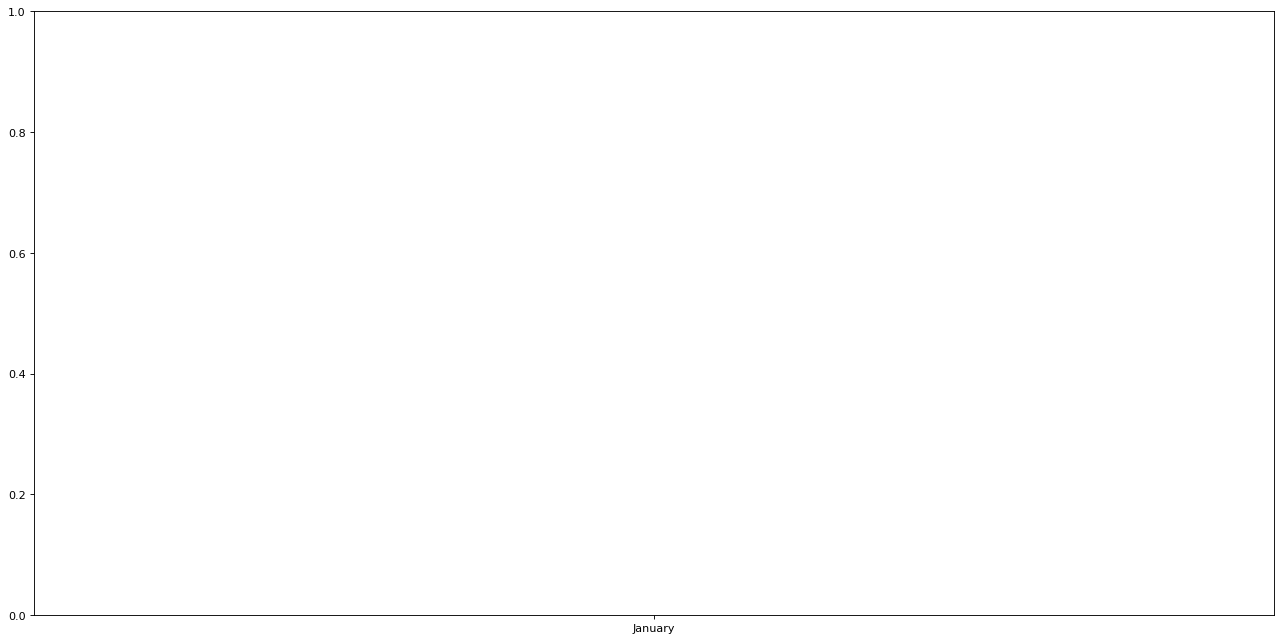

In [91]:
fig, ax = plt.subplots(num=None, figsize=(20, 10), dpi=80)

labels = ['January','February','March','April', 'May','June','July','August','September','October','November','December']

width = .6

ax.bar(labels, one, width,  label='Recreational - Customer')
ax.bar(labels, two, width,  bottom=one,label='Rush Hour - Customer')
ax.bar(labels, three, width,  bottom=two+one,label='Weekend - Customer')
ax.bar(labels, four, width,  bottom=one+two+three,label='Recreational - Subscriber')
ax.bar(labels, five, width,  bottom=one + two + three + four,label='Rush Hour - Subscriber')
ax.bar(labels, six, width,  bottom=one + two + three + four + five,label='Weekend - Subscriber')

ax.set_ylabel('Number of Riders')
ax.set_title('Time period breakdown of R  iders')
ax.legend()
plt.xticks(rotation='vertical')

plt.show()